<a href="https://colab.research.google.com/github/Park-hanna/BDA_study/blob/main/Computer%20Vision/chest_xray_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/aakashnain/beating-everything-with-depthwise-convolution/notebook

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parkhannah833","key":"78bf44606c362ad274d8621ef9b609e9"}'}

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions list

ref                                                                                           deadline             category             reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection                          2023-06-14 23:59:00  Featured         $1,000,000        925           False  
https://www.kaggle.com/competitions/asl-fingerspelling                                        2023-08-10 23:59:00  Research           $200,000          0           False  
https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction                 2023-06-08 23:59:00  Research           $100,000        960           False  
https://www.kaggle.com/competitions/2023-kaggle-ai-report                                     2023-07-05 23:59:00  Analytics           $70,0

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:12<00:00, 155MB/s]
100% 2.29G/2.29G [00:13<00:00, 188MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import load_img => tf.keras.utils.load_img,
#from keras.preprocessing.image import img_to_array => tf.keras.utils.img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConvolution2D

import tensorflow as tf
# from keras.layers.merge import concatenate => tf.keras.laters.concatenate

from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import batch_normalization
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K

color = sns.color_palette()
%matplotlib inline


In [ ]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
data_dir = Path('/content/chest_xray')

train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [ ]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_data = []

for img in normal_cases:
  train_data.append((img, 0))

for img in pneumonia_cases:
  train_data.append((img, 1))

train_data = pd.DataFrame(train_data, columns = ['image', 'label'], index = None)

train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data.head()

,image,label
0,/content/chest_xray/train/NORMAL/IM-0569-0001....,0
1,/content/chest_xray/train/NORMAL/IM-0505-0001-...,0
2,/content/chest_xray/train/PNEUMONIA/person1454...,1
3,/content/chest_xray/train/PNEUMONIA/person348_...,1
4,/content/chest_xray/train/PNEUMONIA/person480_...,1


* NORMAL: These are the samples that describe the normal (no pneumonia) case.
* PNEUMONIA: This directory contains those samples that are the pneumonia cases.

1    3875
0    1341
Name: label, dtype: int64


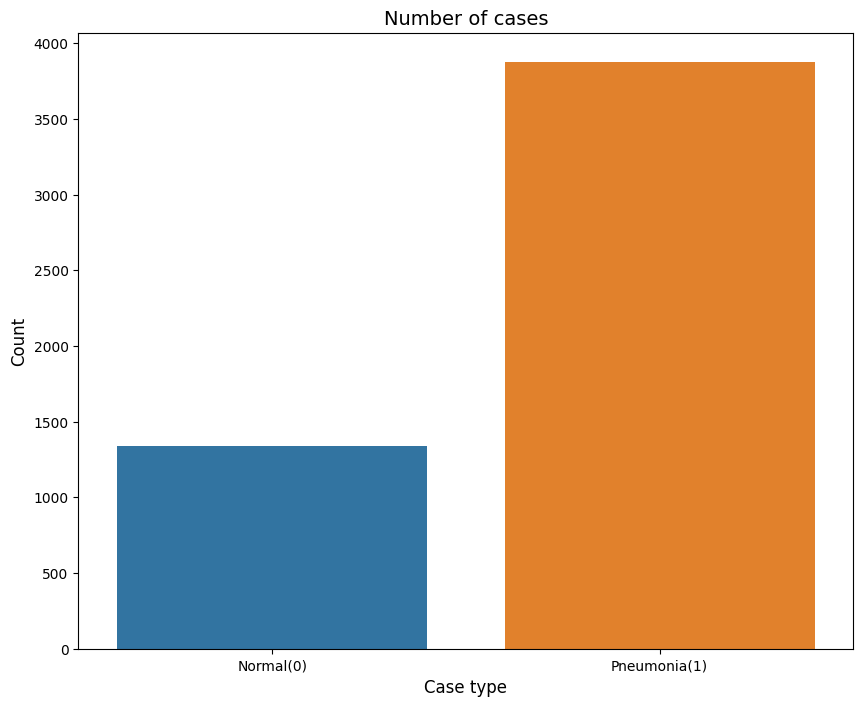

In [ ]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# plot the results
plt.figure(figsize=(10, 8))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.title('Number of cases', fontsize= 14)
plt.xlabel('Case type', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)','Pneumonia(1)' ])
plt.show()

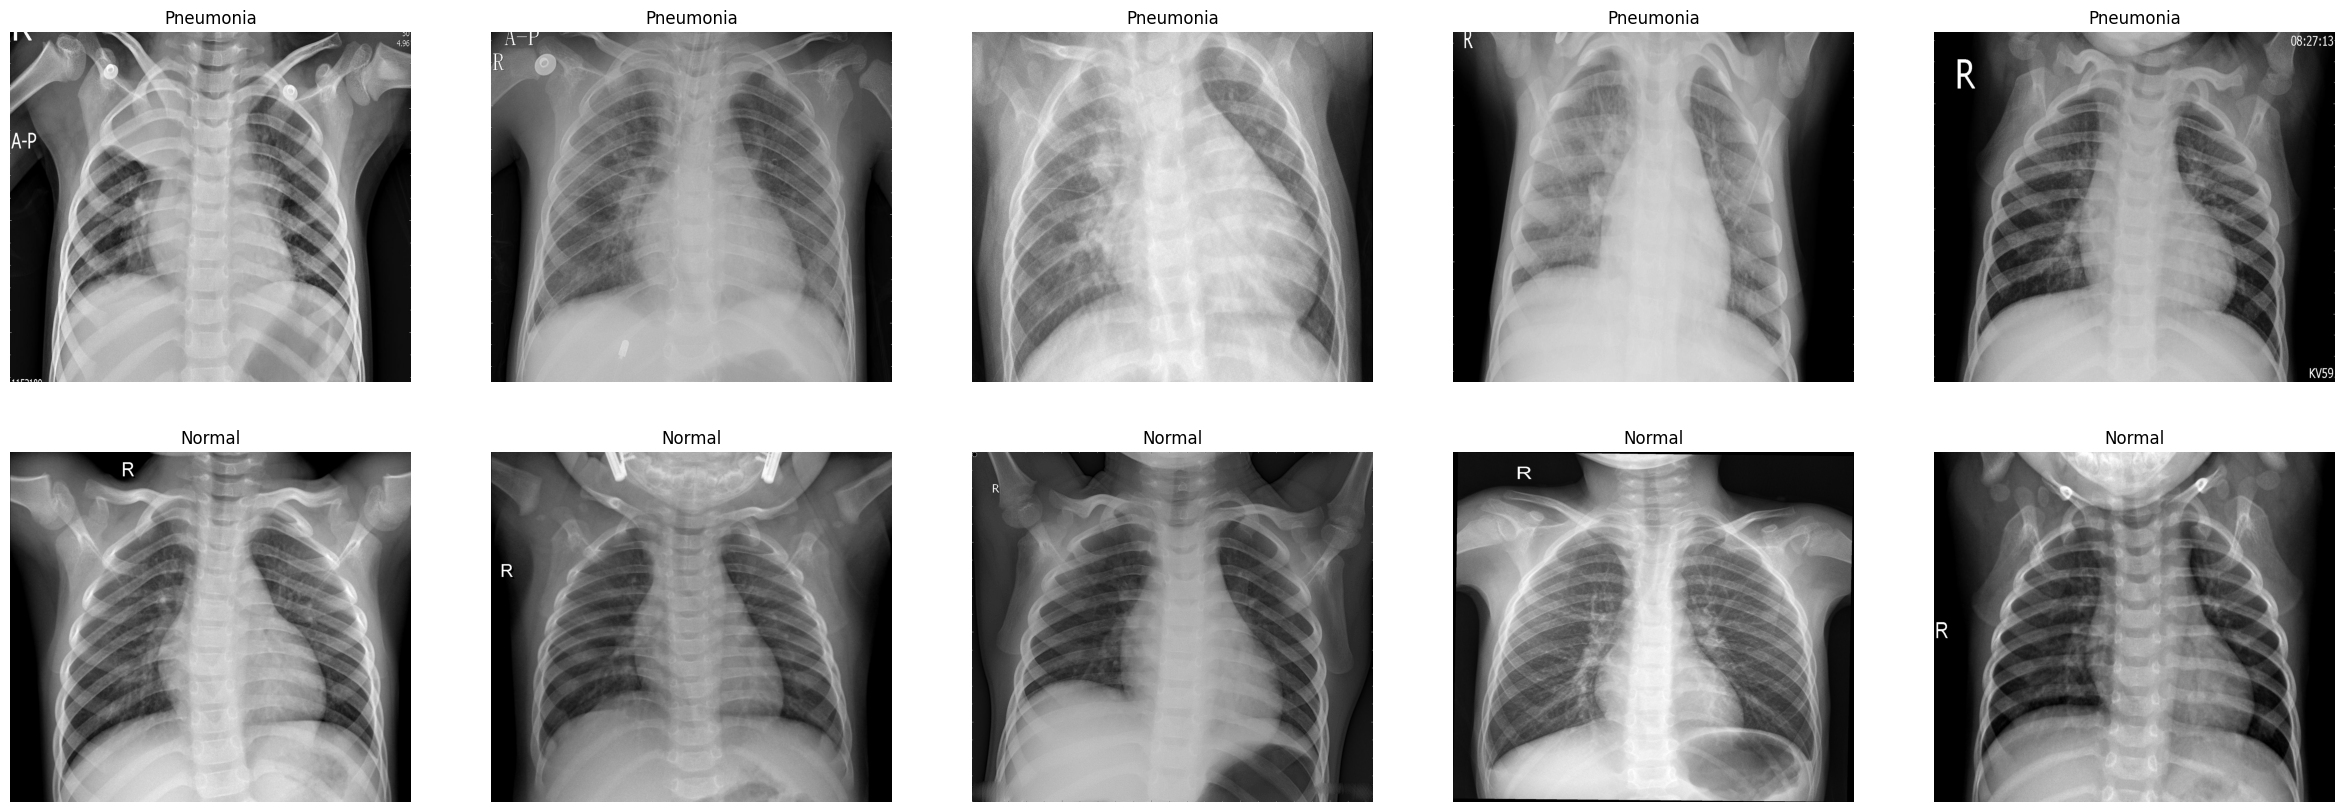

In [ ]:
# get few samples for both the classes

pneumonia_samples = (train_data[train_data['label'] == 1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label'] == 0]['image'].iloc[:5]).tolist()

# concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# plot the data
f, ax = plt.subplots(2, 5, figsize = (30, 10))
for i in range(10):
  img = imread(samples[i])
  ax[i//5, i%5].imshow(img, cmap='gray')
  if i<5:
    ax[i//5, i%5].set_title('Pneumonia')
  else:
    ax[i//5, i%5].set_title('Normal')
  ax[i//5, i%5].axis('off')
  ax[i//5, i%5].set_aspect('auto')
plt.show()

In [ ]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

valid_data = []
valid_labels = []

for img in normal_cases:
  img = cv2.imread(str(img))
  img = cv2.resize(img, (224, 224))
  if img.shape[2] == 1:
    img = np.dstack([img, img, img])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype(np.float32)/255.
  label = to_categorical(0, num_classes = 2)
  valid_data.append(img)
  valid_labels.append(label)

for img in pneumonia_cases:
  img = cv2.imread(str(img))
  img = cv2.resize(img, (224, 224))
  if img.shape[2] == 1:
    img = np.dstack([img, img, img])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype(np.float32)/255.
  label = to_categorical(1, num_classes =2)
  valid_data.append(img)
  valid_labels.append(label)

valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print('Total number of validation examples : ', valid_data.shape)
print('Total number of labels : ', valid_labels.shape)

Total number of validation examples :  (16, 224, 224, 3)
Total number of labels :  (16, 2)


# Augmentation

In [ ]:
# Augmentation sequence
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate = 20), # roataion
    iaa.Multiply((1.2, 1.5))]) # random brightness

In [ ]:
def data_gen(data, batch_size):
  n = len(data)
  steps = n//batch_size

  batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
  batch_labels = np.zeros((batch_size, 2), dtype = np.float32)

  indices = np.arange(n)

  i = 0
  while True:
    np.random.shuffle(indices)
    count = 0
    next_batch = indices[(i*batch_size) : (i+1)*batch_size]
    for j, idx in enumerate(next_batch):
      img_name = data.iloc[idx]['image']
      label = data.iloc[idx]['label']

      encoded_label = to_categorical(label, num_classes = 2)
      img = cv2.imread(str(img_name))
      img = cv2.resize(img, (224, 224))

      if img.shape[2] == 1:
        img = np.dstack([img, img, img])

      orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      orig_img = img.astype(np.float32)/255.

      batch_data[count] = orig_img
      batch_labels[count] = encoded_label

      if label == 0 and count < batch_size -2:
        aug_img1 = seq.augment_image(img)
        aug_img2 = seq.augment_image(img)

        aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
        aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)

        aug_img1 = aug_img1.astype(np.float32)/255.
        aug_img2 = aug_img2.astype(np.float32)/255.

        batch_data[count+1] = aug_img1
        batch_labels[count+1] = encoded_label

        batch_data[count+2] = aug_img2
        batch_labels[count+2] = encoded_label
        count += 2

      else:
        count += 1

      if count == batch_size -1:
        break

    i+=1
    yield batch_data, batch_labels

    if i >= steps:
      i = 0

# Model

In [ ]:
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras.layers.convolutional.separable_conv2d import SeparableConv2D
def build_model():
  input_img = Input(shape=(224,224,3), name='ImageInput')
  x = Conv2D(64, (3, 3), activation = 'relu', padding='same', name='Conv1_1')(input_img)
  x = Conv2D(64, (3, 3), activation = 'relu', padding='same', name='Conv1_2')(x)
  x = MaxPooling2D((2,2), name='pool1')(x)

  x = SeparableConv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'Conv2_1')(x)
  x = SeparableConv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'Conv2_2')(x)
  x = MaxPooling2D((2,2), name='pool2')(x)

  x = SeparableConv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'Conv3_1')(x)
  x = BatchNormalization(name = 'bn1')(x)
  x = SeparableConv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'Conv3_2')(x)
  x = BatchNormalization(name = 'bn2')(x)
  x = SeparableConv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'Conv3_3')(x)
  x = MaxPooling2D((2,2), name='pool3')(x)

  x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
  x = BatchNormalization(name='bn3')(x)
  x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
  x = BatchNormalization(name='bn4')(x)
  x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
  x = MaxPooling2D((2,2), name='pool4')(x)

  x = Flatten(name = 'flatten')(x)
  x = Dense(1024, activation = 'relu', name = 'fc1')(x)
  x = Dropout(0.7, name = 'dropout1')(x)
  x = Dense(512, activation = 'relu', name = 'fc2')(x)
  x = Dropout(0.5, name = 'dropout2')(x)
  x = Dense(2, activation = 'softmax', name = 'fc3')(x)

  model = Model(inputs = input_img, outputs = x)
  return model

In [ ]:
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [ ]:
!kaggle datasets download -d keras/vgg16

 97% 525M/542M [00:03<00:00, 187MB/s]
100% 542M/542M [00:03<00:00, 166MB/s]


In [ ]:
!unzip vgg16.zip

Archive:  vgg16.zip
  inflating: imagenet_class_index.json  
  inflating: vgg16_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5  


In [ ]:
f = h5py.File('/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

w, b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w, b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w, b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w, b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [ ]:
opt = Adam(lr = 0.0001, decay = 1e-5)
es = EarlyStopping(patience = 5)
chkpt = ModelCheckpoint(filepath = 'best_model_todate', save_best_only = True, save_weights_only = True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
batch_size = 16
nb_epochs = 20

train_data_gen = data_gen(data=train_data, batch_size = batch_size)

nb_train_steps = train_data.shape[0]//batch_size

print('Number of training and validation steps : {} and {}'.format(nb_train_steps, len(valid_data)))

Number of training and validation steps : 326 and 16


In [ ]:
# fit the model
history = model.fit_generator(train_data_gen, epochs = nb_epochs, steps_per_epoch = nb_train_steps,
                              validation_data= (valid_data, valid_labels), callbacks = [es, chkpt],
                              class_weight = {0:1.0, 1:0.4})

<ipython-input-22-1977d4fc4baf>:2: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen, epochs = nb_epochs, steps_per_epoch = nb_train_steps,


Epoch 1/20
326/326 [==============================] - ETA: 0s - batch: 162.5000 - size: 16.0000 - loss: 0.2514 - acc: 0.7333

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


326/326 [==============================] - 99s 254ms/step - batch: 162.5000 - size: 16.0000 - loss: 0.2514 - acc: 0.7333 - val_loss: 0.7381 - val_acc: 0.5000
Epoch 2/20
326/326 [==============================] - 72s 217ms/step - batch: 162.5000 - size: 16.0000 - loss: 0.0824 - acc: 0.9450 - val_loss: 0.7824 - val_acc: 0.5000
Epoch 3/20
326/326 [==============================] - 72s 216ms/step - batch: 162.5000 - size: 16.0000 - loss: 0.0659 - acc: 0.9555 - val_loss: 1.1134 - val_acc: 0.5000
Epoch 4/20
326/326 [==============================] - 79s 239ms/step - batch: 162.5000 - size: 16.0000 - loss: 0.0556 - acc: 0.9661 - val_loss: 0.2335 - val_acc: 0.9375
Epoch 5/20
326/326 [==============================] - 71s 215ms/step - batch: 162.5000 - size: 16.0000 - loss: 0.0379 - acc: 0.9751 - val_loss: 0.3921 - val_acc: 0.8750
Epoch 6/20
326/326 [==============================] - 71s 214ms/step - batch: 162.5000 - size: 16.0000 - loss: 0.0384 - acc: 0.9757 - val_loss: 0.7982 - val_acc: 0.81

In [ ]:
model.load_weights('')